In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd  
from scipy.sparse.linalg import LinearOperator, lsqr
import h5py
from tcsim.visualization import*
from qutip import*
from tcsim.visualization import*
from tcsim.analyze.dataloader import*

In [39]:
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

def char_squeeze(xy_tuple, amplitude, r, theta, delta_x, delta_y, offset):
    (x,y) = xy_tuple
  
    beta = x+1j*y   
    delta = delta_x + 1j*delta_y

    g = np.real(offset + amplitude*np.exp(-np.abs(beta*np.cosh(r)+beta*np.exp(1j*theta)*np.sinh(r))**2/2)*np.exp(beta*np.conjugate(delta)-np.conjugate(beta)*delta))
    
    return g.ravel()

def twoD_Gaussian(xy_tuple, amplitude, sigma_x, sigma_y, theta, offset):
    (x,y) = xy_tuple    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x)**2) + 2*b*(x)*(y) 
                            + c*((y)**2)))
    return g.ravel()


['163401_panther_ECD_char_pre_postselect_3uv_real.h5',
 '164358_panther_ECD_char_pre_postselect_3uv_real.h5',
 '165356_panther_ECD_char_pre_postselect_3uv_real.h5',
 '170353_panther_ECD_char_pre_postselect_3uv_real.h5',
 '171350_panther_ECD_char_pre_postselect_3uv_real.h5',
 '172347_panther_ECD_char_pre_postselect_3uv_real.h5',
 '173344_panther_ECD_char_pre_postselect_3uv_real.h5',
 '174341_panther_ECD_char_pre_postselect_3uv_real.h5',
 '175338_panther_ECD_char_pre_postselect_3uv_real.h5',
 '180336_panther_ECD_char_pre_postselect_3uv_real.h5',
 '181333_panther_ECD_char_pre_postselect_3uv_real.h5',
 '182330_panther_ECD_char_pre_postselect_3uv_real.h5']

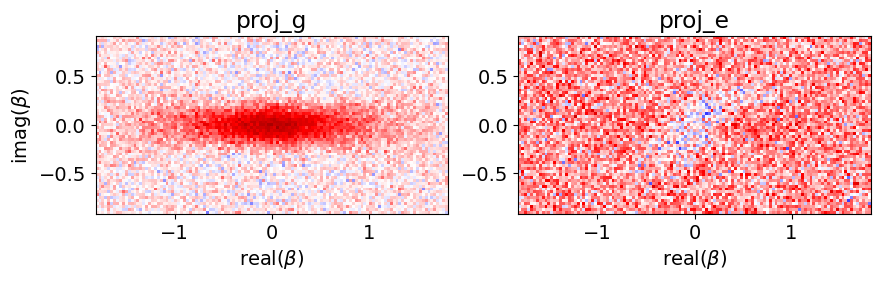

In [75]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os

files1 = []
files2 = []
files = []

d = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
files = [f for f in os.listdir(d) if f.endswith('panther_ECD_char_pre_postselect_3uv_real.h5')]

dg = []
de = []

#files = files[-5:-1]

for kk in range(len(files)):
    fname = d + files[kk]
    df = h5py.File(fname, "r")
    data = df["data"]
    data_i = data["I"][:]
    x = data["x"][:, 0][:, 0]
    y = data["y"][0, :][:, 0]
    n_points_x = len(x)  # sweep points x
    n_points_y = len(y)  # sweep points y
    thresh = +0.00022 #-3.112326057411744e-05
    ss_data = np.where(data_i < thresh, 1, 0)
    m0 = ss_data[:, 0::3]
    m1 = ss_data[:, 1::3] 
    m2 = ss_data[:, 2::3]
    m1_g = ma.masked_array(m1, mask=m0)
    m2_g = ma.masked_array(m2, mask=m0)

    ## only care about last two measurements
    proj_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1
    proj_e = ma.masked_array(m2, mask=np.logical_not(m1)).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1

    ## condition on the first measurement as well
    double_ps_g = ma.masked_array(m2_g, mask=m1_g).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1
    double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g)).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1

    dg.append(double_ps_g)
    de.append(double_ps_e)

    
dg = np.array(dg)
de = np.array(de)


proj_g = dg.mean(axis=0)
proj_e = de.mean(axis=0)
proj_ge = [proj_g, proj_e]  # m2.mean(axis = 0).reshape(n_points, n_points)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
f1 = ax1.pcolormesh(y, x, proj_g, cmap="seismic", vmax=1, vmin=-1)
f2 = ax2.pcolormesh(y, x, proj_e, cmap="seismic", vmax=1, vmin=-1)
ax1.set_aspect("equal")
ax1.set_xlabel(r"real($\beta$)")
ax1.set_ylabel(r"imag($\beta$)")
ax1.set_title('proj_g')
ax2.set_aspect("equal")
ax2.set_xlabel(r"real($\beta$)")
ax2.set_title('proj_e')
# fig.colorbar(f2)

files

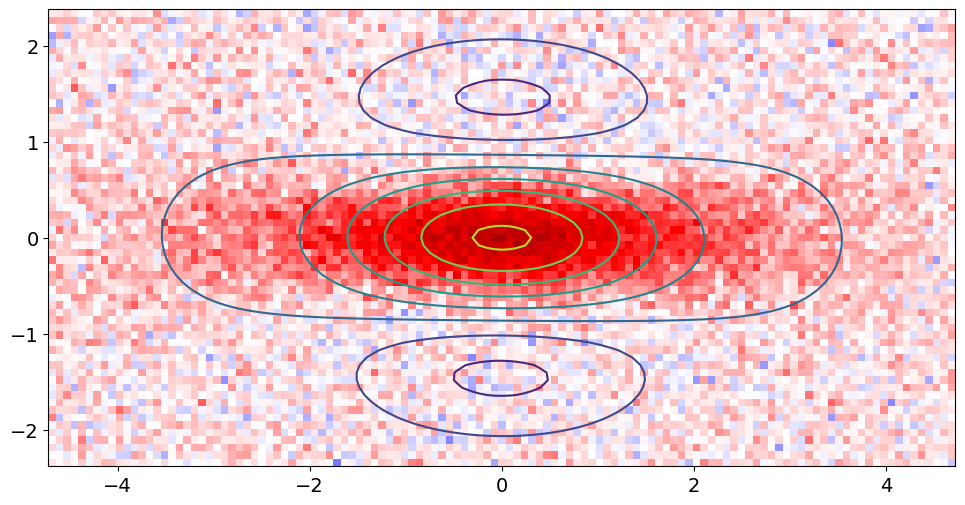

In [76]:
import scipy.optimize as opt
""" 
Use the above plot to make good intial guesses!

"""
scaling = 2.6
# add some noise to the data and try to fit the data generated beforehand
initial_guess = (0.8, 2, 0, 0, 0,0) # upper blob


xvec = x*scaling # i define it like this in case i want to slice x
yvec = y*scaling
X, Y = np.meshgrid(yvec, xvec)

data = proj_g

popt1, pcov1 = opt.curve_fit(char_squeeze, (X, Y), data.flatten(), p0=initial_guess)



data_fitted1 = char_squeeze((X, Y), *popt1)

fig, ax = plt.subplots(1, 1)

ax.pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
ax.contour(yvec,xvec, data_fitted1.reshape(len(x),len(y)))
ax.set_aspect("equal")
plt.show()

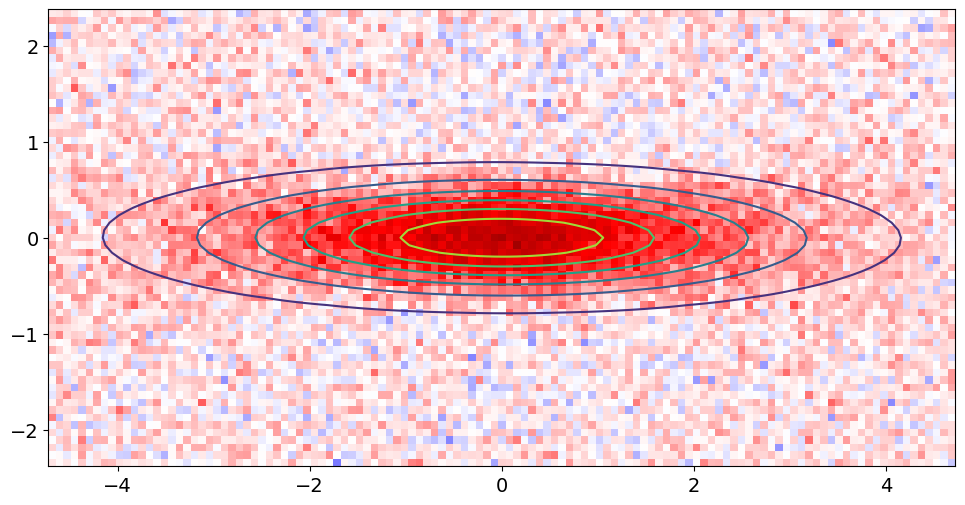

In [77]:
""" 
Use the above plot to make good intial guesses!

"""
scaling = 2.6
# add some noise to the data and try to fit the data generated beforehand
initial_guess = (0.5,  0.1, 0.6, -np.pi/2, 0) # upper blob


xvec = x*scaling # i define it like this in case i want to slice x
yvec = y*scaling
X, Y = np.meshgrid(yvec, xvec)

data = proj_g

popt1, pcov1 = opt.curve_fit(twoD_Gaussian, (X, Y), data.flatten(), p0=initial_guess)



data_fitted1 = twoD_Gaussian((X, Y), *popt1)

fig, ax = plt.subplots(1, 1)

ax.pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
ax.contour(yvec,xvec, data_fitted1.reshape(len(x),len(y)))
ax.set_aspect("equal")
plt.show()

In [78]:
""" quick note: while the sigma ratio can be easily extracted, extracting the displacement isnt as straight forward. 

1. For a cat state visualized with the characteristic function, the blobs are positioned at 2*alpha and -2*alpha. 

2. The x,y scale of the experimental data is not exact but only approximate yet. Hence, any alpha extracted from the data has to be corrected with the correct scaling factor.


 """
print("First Blob")
print("sigmax:",(popt1[2]))
print("sigmay:",(popt1[1]))
print("sigma ratio:",(popt1[1]/popt1[2]))
print("squeezing in db x:",20*np.log10((popt1[2])))
print("squeezing in db y:",20*np.log10((popt1[1])))
print('angle in degree:', np.rad2deg(popt1[3]))

First Blob
sigmax: 1.8795039357778092
sigmay: 0.3554466486498835
sigma ratio: 0.18911726753197053
squeezing in db x: 5.480864789714847
squeezing in db y: -8.984511523761942
angle in degree: -89.82525459100056


Note: poorly picked cuts, not representative..


In [79]:
def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

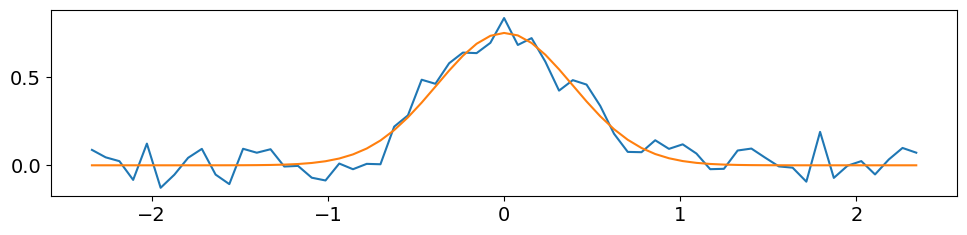

[0.75152907 0.00299857 0.38524531]


In [80]:
xvec = x*scaling # i define it like this in case i want to slice x
data = proj_g[:,60 ]

p0 = [1, 0 , 1.1]
popt1, pcov1 = opt.curve_fit(gauss_1, xvec, data.flatten(), p0=p0)



data_fitted1 = gauss_1(xvec, *popt1)

fig, ax = plt.subplots(1, 1)

ax.plot(xvec, data)
ax.plot(xvec, data_fitted1)
ax.set_aspect("equal")
plt.show()
print(popt1)

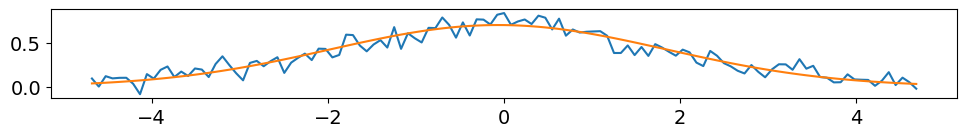

[ 0.70008262 -0.06644763  1.90310773]


In [81]:
yvec = y*scaling # i define it like this in case i want to slice x
data = proj_g[30,: ]

p0 = [1, 0 , 1.1]
popt1, pcov1 = opt.curve_fit(gauss_1, yvec, data.flatten(), p0=p0)



data_fitted1 = gauss_1(yvec, *popt1)

fig, ax = plt.subplots(1, 1)

ax.plot(yvec, data)
ax.plot(yvec, data_fitted1)
ax.set_aspect("equal")
plt.show()
print(popt1)

In [33]:
a = char_squeeze((0,0.8),0, 0.4, 0, 0, 0,0)

In [34]:
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

dtype('float64')

In [38]:
calc_squeez_parameter(1.9)

0.21874558383443438

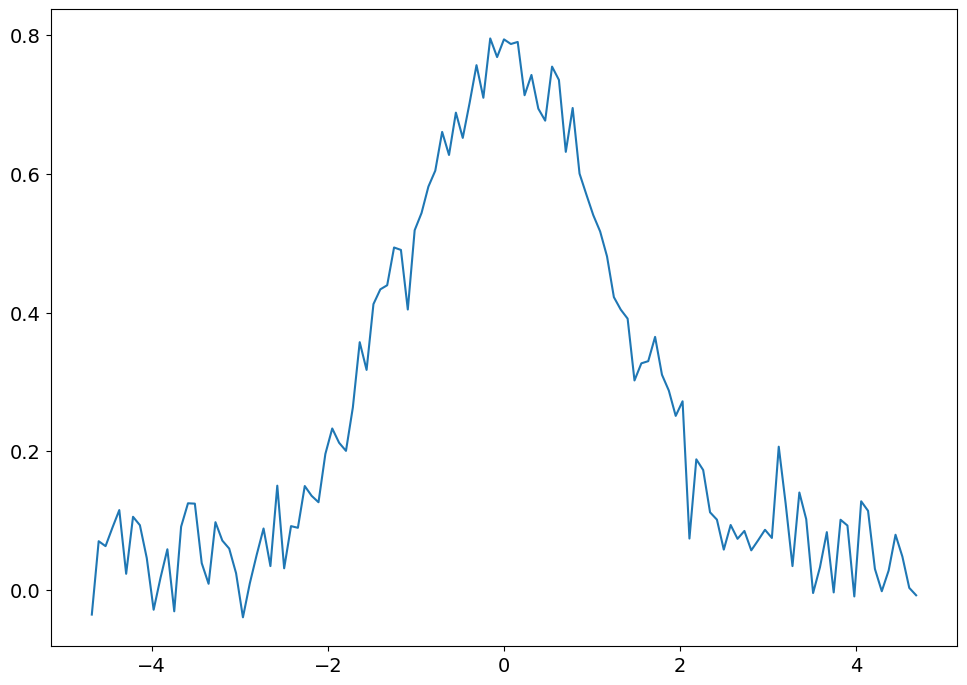

In [50]:
plt.plot(yvec,proj_g[30,: ])

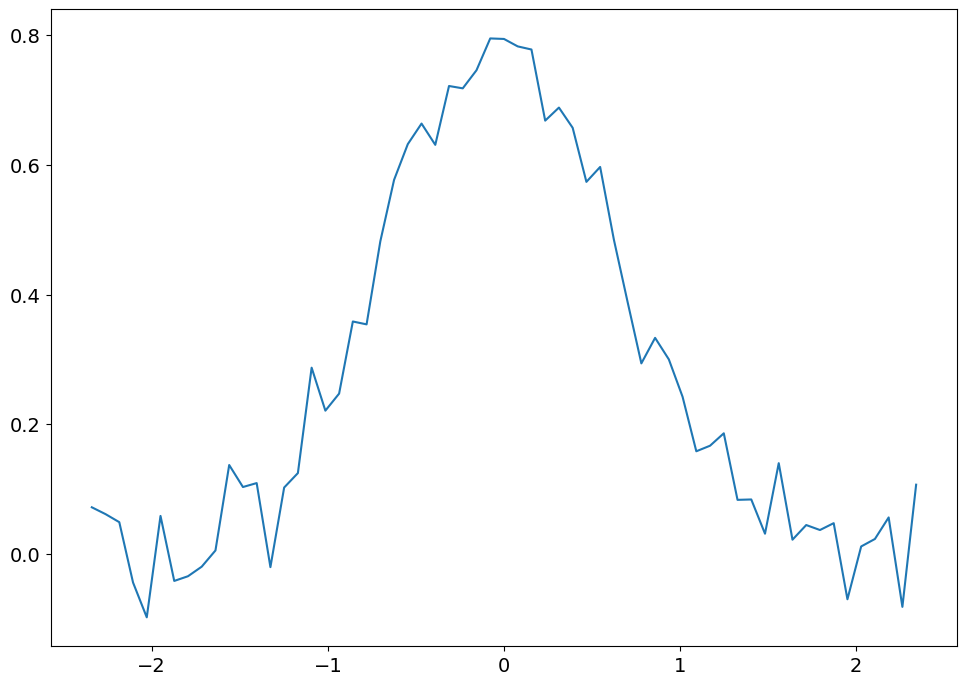

In [55]:
plt.plot(xvec,proj_g[:,60 ])

In [54]:
len(xvec)
len(yvec)

121